In [1]:
import os
import csv
import paramiko
import gzip

import pymysql
from sshtunnel import SSHTunnelForwarder

from tqdm import tqdm

from datetime import timedelta
from datetime import date
from datetime import datetime

import pandas as pd


In [2]:
from platform import python_version 
python_version() 

'3.8.10'

In [2]:
database = "clinical_merge_v5_2020q4"

ped_data = '/home/kel2158/Projects/Heritability_Base_Data/pedigree_v3_updated_results/'
output_folder= '/home/kel2158/Projects/COVIDHerit/data/12_29_21/'
hhid_folder = '/home/kel2158/Projects/hhid_update/data/'


demo_file = output_folder+'demo.txt.gz'
hosp_days_file = output_folder+'days_hosp.txt.gz'
covid_nopro_file = output_folder+'covid_noproband.txt.gz'
covid_file = output_folder+'covid.txt.gz'

hosp_stat_file = output_folder + 'hosp_stat.txt.gz'
hosp_stat_nopro_file = output_folder + 'hosp_stat_noproband.txt.gz'
high_deg_file = output_folder + 'covid_high_degfam.txt.gz'
high_deg_nopro_file = output_folder + 'covid_high_degfam_noproband.txt.gz'


#Input files
finename_fam_input = ped_data+"family_v3.txt.gz"
filename_hhid =  hhid_folder+'hhid_trimmed_notcln.txt.gz'
buildid_file = hhid_folder+"buildid_notcln.txt.gz"
filename_ped_input =  ped_data+"pedigree_v3.txt.gz"

In [3]:
def return_sign_in(login_loc = '/home/kel2158/login.txt'):
    login_dict = dict()
    with open(login_loc, "r") as file:
        for line in file.readlines():
            login_dict[ line.split(",")[0]] = line.split(",")[1].strip()
    return(login_dict)

In [4]:
login_dict = return_sign_in()

ssh = paramiko.SSHClient()
ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())
ssh.connect('10.144.220.21', username=login_dict['user'], password=login_dict['mimir_pw'])


In [5]:
server = SSHTunnelForwarder(
    '10.144.220.21',
    ssh_username='kel2158',
    ssh_password=login_dict['mimir_pw'],
    remote_bind_address=('127.0.0.1', 3306)
)
server.start()

db = pymysql.connect(
    host='127.0.0.1',
    port=server.local_bind_port,
    user=login_dict['user'],
    password=login_dict["db_pw"],
    db=database
)

cur = db.cursor()



## Pull Data

In [6]:
#Read in time to first pcr trait file 
file_name = filename_ped_input
gfile = gzip.open(file_name)
ped_df = pd.read_csv(gfile,sep='\t')
gfile.close()



In [7]:
#Read in time to first pcr trait file 
file_name = demo_file
gfile = gzip.open(file_name)
demo_df = pd.read_csv(gfile,sep='\t')
gfile.close()



In [8]:
#Read in time to first pcr trait file 
file_name = finename_fam_input
gfile = gzip.open(file_name)
fam_df = pd.read_csv(gfile,sep='\t')
gfile.close()


In [9]:
#Read in HHID file 
file_name = filename_hhid
gfile = gzip.open(file_name)
hhid_df = pd.read_csv(gfile,sep='\t')
gfile.close()


mrn2hhid = dict(zip( hhid_df["mrn"], hhid_df["trimmed_hhid"] ))

In [10]:
#Read in BuildingID file 
file_name = buildid_file
gfile = gzip.open(file_name)
bid_df = pd.read_csv(gfile,sep='\t')
gfile.close()


mrn2bid = dict(zip( bid_df["mrn"], bid_df["building_id"] ))

In [11]:
#Read in time to first pcr trait file 
file_name = time2pcr_file
gfile = gzip.open(file_name)
time2pcr_df = pd.read_csv(gfile,sep='\t')
gfile.close()


In [12]:
#Read in covid susceptibility file
file_name = covid_file
gfile = gzip.open(file_name)
cov_df = pd.read_csv(gfile,sep='\t')
gfile.close()

In [13]:
#Read in cov noproband
file_name = covid_nopro_file
gfile = gzip.open(file_name)
covnopro_df = pd.read_csv(gfile,sep='\t')
gfile.close()


In [14]:
#Read in days_hosp
file_name = hosp_days_file
gfile = gzip.open(file_name)
hospday_df = pd.read_csv(gfile,sep='\t')

gfile.close()


In [15]:
#Read in hospitalization_stat
file_name = hosp_stat_file
gfile = gzip.open(file_name)
hosp_df = pd.read_csv(gfile,sep='\t')

gfile.close()


In [16]:
#Read in hospitalization_stat_noproband
file_name = hosp_stat_nopro_file
gfile = gzip.open(file_name)
hosp_nopro_df = pd.read_csv(gfile,sep='\t')

gfile.close()


In [17]:
#Read in high_deg
file_name = high_deg_file
gfile = gzip.open(file_name)
high_deg_df = pd.read_csv(gfile,sep='\t')

gfile.close()


In [18]:
#Read in high_deg_noproband
file_name = high_deg_nopro_file
gfile = gzip.open(file_name)
high_deg_nopro_df = pd.read_csv(gfile,sep='\t')

gfile.close()


In [19]:
pull_data_query = """SELECT *
FROM clinical_relationships_v3.all_relationships_to_generate_pedigree_file"""


cur.execute(pull_data_query)
rawdata = cur.fetchall()

rel_df = pd.DataFrame(list(rawdata),
                    columns=["mrn","relationship","relation_mrn","provided_relationship",
                             ])

In [20]:
pull_data_query = """SELECT *
FROM clinical_relationships.relationships_degree"""


cur.execute(pull_data_query)
rawdata = cur.fetchall()

reldegree_df = pd.DataFrame(list(rawdata),
                    columns=["relationship","degree"
                             ])

rel2degree = dict( zip( reldegree_df["relationship"],reldegree_df["degree"] ) ) 

In [26]:
db.close()
server.stop() 

## Functions

In [21]:
def pull_fam_count( pheno, df, print_res = True, \
                   return_fams_df=False, type_pheno="binary_withproband",
                   return_patient_limited_df = False ):
    
    """Returns the number of families in a phenotype for SOLAR based on pheno 
     Needs phenotype column, famid column and ptid column"""    
    
    #subset on phenotype of interest and those in our pedigree
    df_phenosub = df[ (df["pheno"] == pheno ) 
                       &  (~df["famid"].isnull())] 
    
    #Get the total number of  members in each fam and then number of cases
    df_phenogrouped = df_phenosub.groupby( 'famid' )\
        .agg({ "ptid":"count","value":sum })\
        .reset_index()\
        .rename(columns={ "ptid":"num_fam_members","value":"num_cases" })
    
    #Subset to fams that will be included in SOLAR
    #ie has more than one family member an at least one case in each family
    if type_pheno == "binary_withproband":
        solar_fams_df = df_phenogrouped[ (df_phenogrouped["num_fam_members"] > 1) \
                                        & (df_phenogrouped["num_cases"] > 0) ]
    
    else:
         solar_fams_df = df_phenogrouped[ (df_phenogrouped["num_fam_members"] > 1)]
    
    solar_limited_df = df_phenosub[ df_phenosub["famid"].isin(solar_fams_df["famid"].unique())]
    solar_limited_df.drop_duplicates(inplace=True)
    solar_patients = set( solar_limited_df["ptid"] )
    
    
    
    if print_res:
            print(f'There are {len(solar_fams_df)} SOLAR families')
    
    if return_fams_df:
        return solar_fams_df, solar_patients
    
    elif return_patient_limited_df == True:
        return solar_limited_df
    
    else:
        return(len( solar_fams_df) )
    

## Process Data

In [22]:
#Map for differences in how SOLAR includes people
#Options: binary_withproband OR quant_or_binary_noproband
pheno2type = {   
"covid":"binary_withproband",
"covid_noproband":"binary_noproband",
"days_hosp":"quant",
    "hosp_stat":"binary_withproband",
    "hosp_stat_nopro":"binary_noproband",
    "covid_highdeg_fam":"binary_withproband",
    "covid_highdeg_nopro":"binary_noproband",
}



In [23]:
#Info for mapping
mrn2sex = dict(zip( demo_df["ptid"],demo_df["sex"] ))
mrn2famid = dict(zip( fam_df["ptid"],fam_df["famid"] ))

#Map famid to demo df
demo_df["famid"]  = demo_df["ptid"].map(mrn2famid)

pheno_dfs = [cov_df, covnopro_df, 
             hospday_df,hosp_df,hosp_nopro_df,
             high_deg_df,high_deg_nopro_df]


In [24]:
def merge_limit2solar(df, pheno):
    #Merge with demo data
    df = df.merge(demo_df, how="left", left_on="ptid", right_on="ptid") 
    
    #Get patients included in solar runs
    df = pull_fam_count(pheno, df,
                                type_pheno=pheno2type[pheno],
                                return_patient_limited_df=True)
    return df



In [27]:
#Map demo and limit to SOLAR patients
covnopro_limited_df = merge_limit2solar(covnopro_df,"covid_noproband")
cov_limited_df = merge_limit2solar(cov_df,"covid")
hospday_limited_df = merge_limit2solar(hospday_df,"days_hosp")

hosp_limited_df = merge_limit2solar(hosp_df,"hosp_stat")
hosp_nopro_limited_df = merge_limit2solar(hosp_nopro_df,"hosp_stat_nopro")
highdeg_limited_df = merge_limit2solar(high_deg_df,"covid_highdeg_fam")
highdeg_nopro_limited_df = merge_limit2solar(high_deg_nopro_df,"covid_highdeg_nopro")


df_limited = [covnopro_limited_df,cov_limited_df,hospday_limited_df ,
             hosp_limited_df,hosp_nopro_limited_df,highdeg_limited_df,highdeg_nopro_limited_df]

There are 5676 SOLAR families
There are 1324 SOLAR families
There are 158 SOLAR families
There are 115 SOLAR families
There are 158 SOLAR families
There are 296 SOLAR families
There are 962 SOLAR families


In [28]:
holder_list = list()
holder_list_cols = ["pheno","nfemale_cases","nnon_female_cases","nfemale","nnonfemales",
                   "percent_controls_female","percent_female_controls","percent_nonfemale_controls"]
for df in df_limited:

    pheno = df["pheno"].unique()[0]
    print(pheno )
    
    type_pheno = pheno2type[pheno]
    
    if type_pheno == "quant":
        
        count_df = df.groupby( [ "sex" ] ).count().reset_index()
    
        total_f = count_df[ count_df["sex"] == "F" ]["ptid"].sum()
        total_nf = count_df[ count_df["sex"] == "M" ]["ptid"].sum()
    
        f_cases = total_f
        nf_cases = total_nf
       
    
    else:
        count_df = df.groupby( [ "sex", "value" ] ).count().reset_index()
    
        total_f = count_df[ count_df["sex"] == "F" ]["ptid"].sum()
        total_nf = count_df[ count_df["sex"] == "M" ]["ptid"].sum()
    
        f_cases = count_df[ ( count_df["sex"] == "F") & ( count_df["value"] == 1) ]["ptid"].sum()
        nf_cases = count_df[ ( count_df["sex"] == "M") & ( count_df["value"] == 1) ]["ptid"].sum()
    
    
    percent_f = total_f/(total_f+total_nf)

    percent_controls_f = round( f_cases/(f_cases+nf_cases)*100 )
    percent_f_controls =  round( f_cases/(total_f)*100)
    percent_nf_controls =  round( nf_cases/(total_nf)*100)
    
    holder_list.append([pheno,f_cases,nf_cases,total_f,total_nf,percent_controls_f,
                       percent_f_controls,percent_nf_controls])
    
    
samp_df = pd.DataFrame(holder_list,columns=holder_list_cols)


covid_noproband
covid
days_hosp
hosp_stat
hosp_stat_nopro
covid_highdeg_fam
covid_highdeg_nopro


In [29]:
samp_df

,pheno,nfemale_cases,nnon_female_cases,nfemale,nnonfemales,percent_controls_female,percent_female_controls,percent_nonfemale_controls
0,covid_noproband,1091,489,8554,4203,69,13,12
1,covid,1091,489,2133,1040,69,51,47
2,days_hosp,214,122,214,122,64,100,100
3,hosp_stat,126,70,158,87,64,80,80
4,hosp_stat_nopro,126,70,214,122,64,59,57
5,covid_highdeg_fam,257,112,624,303,70,41,37
6,covid_highdeg_nopro,257,112,1832,869,70,14,13


In [30]:
covnopro_limited_rel_df = covnopro_limited_df.copy()
covnopro_limited_rel_df["ptid"] = covnopro_limited_rel_df["ptid"].astype(str)

#Merge relationship and pheno and limit to solar families AND both sides of relationship must
#have covid tests so limit rel file where relation_mrn is in pheno_df also
rel_limit_df = covnopro_limited_rel_df.merge( rel_df[ rel_df["relation_mrn"].isin( covnopro_limited_rel_df["ptid"] ) ]
                                         , how='inner', left_on='ptid', right_on='mrn')
 
#Map the degree of relationship    
rel_limit_df["rel_degree"] = rel_limit_df["relationship"].map(rel2degree)

## Check Ethnicity

In [32]:
#Dictionary to map ethnicity to SOLARStrap friendly coding
map_ethnic_dict = { "NOT HISPANIC OR LATINO OR SPANISH ORIGIN":'U',
"DECLINED":'U',
"HISPANIC OR LATINO OR SPANISH ORIGIN":'H',
"AFRICAN AMERICAN":'B',
"MULTI-RACIAL":"Other",
"UNKNOWN":"U",
"CAUCASIAN":"W",
None:"U",
"(null)":'U',
"ASIAN / PACIFIC ISLANDER":"Other",
"AMERICAN INDIAN / ESKIMO":"Other"
                  }

map_race_dict = {'WHITE':'W'
                    , 'BLACK OR AFRICAN AMERICAN':'B'
                    , 'ASIAN':'Other'
                    ,'OTHER COMBINATIONS NOT DESCRIBED':'Other'
                   ,'AMERICAN INDIAN OR ALASKA NATION':'Other'
                   ,'NAT.HAWAIIAN/OTH.PACIFIC ISLAND':'Other'
                    ,'SEPHARDIC JEWISH':'Other'
                       ,'ASHKENAZI JEWISH':'Other'
                    ,'NULL':'NA'
                  , '(null)':'NA'
                  , 'DECLINED':'NA'
              }


In [33]:
#Solar implementation on combining race and ethnicity
def fe_ethnicity_race(mrn, race, ethnicity):
    if race in ('NA','U', 'D'):
        if ethnicity == 'W':
            race = 'White'
        elif ethnicity == 'B':
            race = 'Black'
        elif ethnicity in ('H', 'S', 'O'):
            race = 'Hispanic'
        elif ethnicity in ('NULL', '', 'U', 'D', '2'):
            race = 'Unknown'
        else:
            race = 'Other'
    else:
        if race == 'W':
            if ethnicity == 'H':
                race = 'Hispanic'
            else:
                race = 'White'
        elif race == 'B':
            if ethnicity == 'H':
                race = 'Hispanic'
            else:
                race = 'Black'
        elif race == 'O':
            race = 'Hispanic'
        else:
            race = 'Other'
    
    empi2race_eth[mrn] = race
#    mrn2race_fe[race][mrn] = 1

In [34]:
rel_limit_df["ethnicity_mapped"] = rel_limit_df["ethnic_code"].map(map_ethnic_dict).fillna(rel_limit_df["ethnic_code"])
rel_limit_df["race_mapped"] = rel_limit_df["race_code"].map(map_race_dict).fillna(rel_limit_df["race_code"])

In [35]:
empi2race_eth = defaultdict(dict)

for row in rel_limit_df.iterrows():
    
    mrn = str(row[1]["mrn"])
    race = row[1]["race_mapped"]
    ethnicity = row[1]["ethnicity_mapped"]
    
    fe_ethnicity_race(mrn, race, ethnicity)

In [36]:
def assign_family_ethnicities(fam2empi, empi2demog, print_breakdown=True):
    """
    Assign each family a single ethnicity. This makes the (incorrect) assumption that everyone in the same
    family will have the same ethnicity. However, because there are so much missing data, this is better
    than nothing at all.

    fam2empi        dict, map from family id to a set of patients identifiers that belong in that family
    empi2demog      dict, map from patient identifiers to the demographic data (including self-reported race/ethnicity data)
    """

    print("Identifying most commonly reported ethnicity for each family...")

    eth2fam = defaultdict(set)
    fam2eth = dict()
   
    for fid, members in tqdm(fam2empi.items()):
        

        family_ethnicities = [empi2race_eth[e] for e in members if empi2race_eth.get(e,0) != 0 if empi2race_eth[e] != 'Unknown' ]
        if len(family_ethnicities) == 0:
            mode = 'Unknown'
        else:
            mode = max(set(family_ethnicities), key=family_ethnicities.count)

        eth2fam[mode].add(fid)
        fam2eth[fid] = mode

    if print_breakdown:
        for eth, families in eth2fam.items():
            print( "\t%s: %d" % (eth, len(families)))

    return eth2fam, fam2eth


In [37]:
#map family to patient ID
fam2empi = defaultdict(list)

for row in tqdm( fam_df[ fam_df["ptid"].isin(rel_limit_df["ptid"].astype(int)) ]\
                .iterrows() ):
    fam2empi[row[1]["famid"]].append(row[1]["ptid"].astype(str))

12549it [00:01, 9678.75it/s]


In [38]:
eth2fam, fam2eth = assign_family_ethnicities(fam2empi,empi2race_eth)

Identifying most commonly reported ethnicity for each family...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5591/5591 [00:00<00:00, 88836.52it/s]

	White: 1287
	Black: 714
	Other: 2007
	Hispanic: 1583


In [40]:
rel_limit_df["fam_race_eth"] = rel_limit_df["famid"].map(fam2eth)
rel_limit_df["fe_race_eth"] = rel_limit_df["mrn"].astype(str).map(empi2race_eth)

In [43]:
import statistics

demo_counts = list()
for df in df_limited:
    pheno = df["pheno"].unique()[0]
    
    df["fam_race_eth"] = df["famid"].map(fam2eth)
    df["fe_race_eth"] = df["ptid"].astype(str).map(empi2race_eth)
    
    #patients in phenotype
    df_demo_rel = rel_limit_df[ rel_limit_df["ptid"].isin( df["ptid"].astype(str) )]
    
    #Limit race columns
    df_race_rel = df_demo_rel[["ptid","fe_race_eth"]]
    df_race_rel.drop_duplicates(inplace=True)
    race_group = df_race_rel.groupby("fe_race_eth").count()["ptid"] 
    
    #Get age dataframe
    df_demo_age = df_demo_rel[["ptid","age"]]
    df_demo_age.drop_duplicates(inplace=True)
    
    #Females
    female_patients = len( df_demo_rel[ df_demo_rel["sex"] == "F"]["ptid"].unique() )
    total_patients = len( df_demo_rel["ptid"].unique())

    
    cols = ["pheno","total patients","female_n","female_percent","age",\
            "age_standard_dev","black","hispanic","other","white",\
       "black_percent","hispanic_percent","other_percent","white_percent"]
    
    holder_list = list()
    holder_list.append(pheno)
    holder_list.append(total_patients)
    holder_list.append(female_patients)
    holder_list.append(round( female_patients/total_patients, 2) )
    holder_list.append(df_demo_age["age"].mean())
    holder_list.append(statistics.stdev( df_demo_age["age"]))
    holder_list.extend(race_group.values)
    holder_list.extend(race_group/total_patients)                                 
    
    demo_counts.append(holder_list)

    
demo_combined_df = pd.DataFrame(demo_counts,columns=cols) 

In [44]:
demo_combined_df

,pheno,total patients,female_n,female_percent,age,age_standard_dev,black,hispanic,other,white,black_percent,hispanic_percent,other_percent,white_percent
0,covid_noproband,12549,8404,0.67,39.633038,25.357465,1397,2480,6479,2193,0.111324,0.197625,0.516296,0.174755
1,covid,3111,2087,0.67,40.500161,26.249126,351,692,1746,322,0.112825,0.222437,0.561234,0.103504
2,days_hosp,335,213,0.64,44.958209,28.012584,30,84,205,16,0.089552,0.250746,0.611940,0.047761
3,hosp_stat,244,157,0.64,51.586066,26.769646,26,51,155,12,0.106557,0.209016,0.635246,0.049180
4,hosp_stat_nopro,335,213,0.64,44.958209,28.012584,30,84,205,16,0.089552,0.250746,0.611940,0.047761
5,covid_highdeg_fam,924,622,0.67,42.965368,26.720959,77,253,530,64,0.083333,0.273810,0.573593,0.069264
6,covid_highdeg_nopro,2688,1823,0.68,41.426711,26.269463,248,655,1527,258,0.092262,0.243676,0.568080,0.095982


## Graphs

In [46]:
%matplotlib inline  
import seaborn as sns
import matplotlib.pyplot as plt

In [47]:
#Average number of family members - use noproband covid susceptibility because includes max patients included
count_fam = covnopro_limited_df.groupby(["famid"]).count()["ptid"].reset_index()
np.mean( count_fam["ptid"] )

2.2487667371388302

Text(0, 0.5, 'Number of Families')

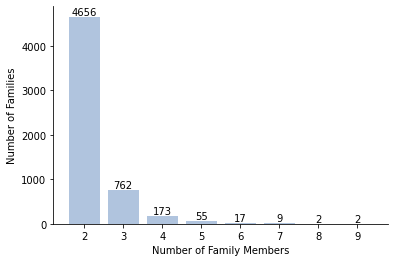

In [50]:
hist_df = count_fam.groupby("ptid").count().reset_index()\
.rename(columns={"ptid":"Number of Family Members","famid":"Number of Families"})

fig, ax = plt.subplots()
bars = ax.bar( hist_df["Number of Family Members"], hist_df["Number of Families"],color="lightsteelblue", )

ax.bar_label(bars)
sns.despine()

plt.xlabel("Number of Family Members")
plt.ylabel("Number of Families")

17336
17336


[Text(0, 0, '6124'), Text(0, 0, '1171'), Text(0, 0, '190'), Text(0, 0, '133')]

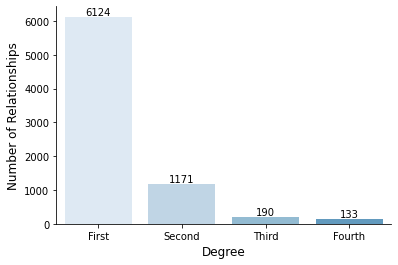

In [52]:
# Set the palette using the name of a palette:
sns.set_palette("Blues")

#Make sure there aren't duplicates because of demo

rel_only_df = rel_limit_df[["ptid","relation_mrn","rel_degree"]]
print( len(rel_limit_df) )

rel_only_df.drop_duplicates(inplace=True)
print( len(rel_only_df) )

#Count of individuals by degree, can be case OR control
degree_counts_all = rel_limit_df.groupby("rel_degree").agg({"mrn":'count'}).reset_index()

degree_counts = degree_counts_all[ degree_counts_all["rel_degree"].isin(["First","Second","Third","Fourth"]) ]

#Divide by 2 since reciprical of every relationship is included
degree_counts["unique_rel_count"] = degree_counts["mrn"]/2
degree_counts.sort_values(by="unique_rel_count", ascending=False, inplace=True)

ax = sns.barplot(x="rel_degree", y="unique_rel_count", \
                 data=degree_counts)
sns.despine()

ax.set_xlabel("Degree", fontsize = 12)
ax.set_ylabel("Number of Relationships", fontsize = 12)
sns.despine()

ax.bar_label(ax.containers[0])

In [53]:
#Map hhid abd bid to patients
rel_limit_df["hhid"] = rel_limit_df["ptid"].astype(int).map(mrn2hhid)
rel_limit_df["bid"] = rel_limit_df["ptid"].astype(int).map(mrn2bid)

rel_limit_df["rel_hhid"] = rel_limit_df["relation_mrn"].astype(int).map(mrn2hhid)
rel_limit_df["rel_bid"] = rel_limit_df["relation_mrn"].astype(int).map(mrn2bid)

In [54]:
#Percent relatives that share hhid (will be the same as bid overlap)
len( rel_limit_df[ rel_limit_df["hhid"] == rel_limit_df["rel_hhid"]]["ptid"].unique())\
/len(rel_limit_df["ptid"].unique())

0.5197226870666986

In [67]:
share_hhid_df = rel_limit_df[ (rel_limit_df['hhid'] == rel_limit_df['rel_hhid'] ) &\
            (rel_limit_df['mrn'] != rel_limit_df['relation_mrn'] )
            
            ]

In [68]:
#percent that live together

degree_hhid_list = list()
for degree in ["First","Second","Third","Fourth"]:
    
    shared_hhid_count = len( share_hhid_df[share_hhid_df["rel_degree"] == degree][["mrn","relation_mrn"]].drop_duplicates() )
    all_degree = len( rel_limit_df[rel_limit_df["rel_degree"] == degree][["mrn","relation_mrn"]].drop_duplicates() )
    
    percent_live_together = shared_hhid_count/all_degree
    #must divide by 2 since reciprical
    total_live_together = shared_hhid_count/2
    total_with_that_rel = all_degree/2
    
    degree_hhid_list.append([degree,total_live_together,total_with_that_rel,percent_live_together])
    

In [69]:
pd.DataFrame(degree_hhid_list,columns=["Degree","N Lives Together","N","Percent lives together"])

,Degree,N Lives Together,N,Percent lives together
0,First,3294.0,6124.0,0.537884
1,Second,255.0,1171.0,0.217763
2,Third,13.0,190.0,0.068421
3,Fourth,9.0,133.0,0.067669


In [72]:
#Percent relatives that share hhid
len( rel_limit_df[ rel_limit_df["bid"] == rel_limit_df["rel_bid"]]["ptid"].unique())\
/len(rel_limit_df["ptid"].unique())


0.5197226870666986